In [2]:
import os
import glob
import math
import obspy
import time
import pandas as pd
from obspy.clients.iris import Client
client = Client()
from obspy.taup import TauPyModel
from matplotlib import pyplot as plt, patches
from matplotlib.patches import Rectangle
from IPython.display import clear_output
import numpy as np

In [3]:
### dirs and files
data_sac = './SAC'     

evt = "20190605171935420" 

evt: 20190605171935420 depth:5.0


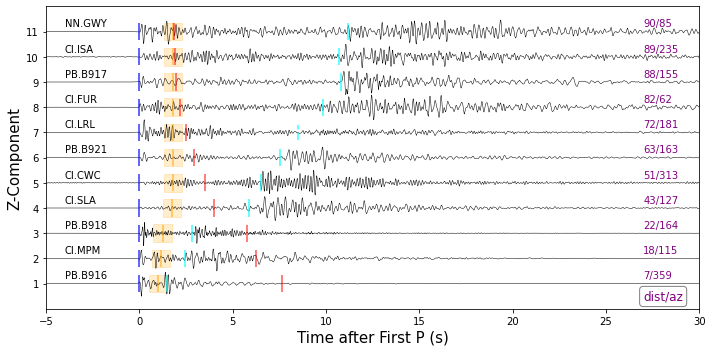

In [4]:
### show event gather - aligned
# phase data -- this is prepared by extracting the phase data from data center
pdf = pd.read_csv(f'{data_sac}/{evt}/UCevt.info',delim_whitespace=True,usecols=["stnm","dist", "az","tp","ts"])
# waveform
for i,sta in enumerate(pdf["stnm"]):
    if i == 0:
        st = obspy.read(f"{data_sac}/{evt}/{sta}*Z.SAC.bp")
    else:
        st += obspy.read(f"{data_sac}/{evt}/{sta}*Z.SAC.bp")

fig = plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.2,hspace=0.2)
ax = fig.add_subplot(1, 1, 1)

tb = -5 ## relative to first P
te = 30
t = np.arange(tb,te,st[0].stats.delta)
model = TauPyModel(f"./hk.npz")

ascale = 0.5
for j,trace in enumerate(st):
    stnm = pdf["stnm"][j]
    tp = pdf["tp"][j]
    indx1 = int((tp+tb-trace.stats.sac.b)/trace.stats.delta)
    indx2 = int((tp+te-trace.stats.sac.b)/trace.stats.delta)
    ax.plot(t[0:indx2-indx1],j+1+ascale*trace.data[indx1:indx2]/np.max(np.abs(trace.data[indx1:indx2])),linewidth=0.5,color="black")
    ax.plot([0, 0], [j+1-0.3, j+1+0.3], color="blue", alpha=0.6, linewidth=2)
    # sPL
    sdep = trace.stats.sac.evdp
    rdist = trace.stats.sac.gcarc
    arrival1 = model.get_ray_paths(source_depth_in_km=sdep, distance_in_degree=rdist, phase_list=['p','P'])
    arrival2 = model.get_ray_paths(source_depth_in_km=sdep, distance_in_degree=rdist, phase_list=['sPg'])
    arrival3 = model.get_ray_paths(source_depth_in_km=sdep, distance_in_degree=rdist, phase_list=['PvmP'])
    arrival4 = model.get_ray_paths(source_depth_in_km=sdep, distance_in_degree=rdist, phase_list=['s','S'])
    if len(arrival2) > 0:
        dtsplr = arrival2[0].time - arrival1[0].time
        ax.plot([dtsplr, dtsplr], [j+1-0.3, j+1+0.3], color="orange", alpha=0.5, linewidth=2)
        rect = patches.Rectangle((dtsplr-0.5, j+1-0.35), 1.0, 0.7, color='orange',alpha=0.2)
        ax.add_patch(rect)
    dtpmpr = arrival3[0].time - arrival1[0].time
    ax.plot([dtpmpr, dtpmpr], [j+1-0.3, j+1+0.3], color="red", alpha=0.5, linewidth=2)
    ax.text(tb+1, j+1+0.2, "{}".format(stnm), fontsize=10)
    ax.text(te-3, j+1+0.2, "{:.0f}/{:.0f}".format(pdf["dist"][j],pdf["az"][j]), fontsize=10, color="purple")
    ts = pdf["ts"][j]
    if not np.isnan(ts):
        ax.plot([ts-tp, ts-tp], [j+1-0.3, j+1+0.3], color="cyan", alpha=0.6, linewidth=2)
    else:
        ax.plot([arrival4[0].time-tp, arrival4[0].time-tp], [j+1-0.3, j+1+0.3], color="cyan", alpha=0.6, linewidth=2, linestyle="--")
print("evt: {} depth:{:.1f}".format(evt,sdep))
ax.text(te-3, 0+0.35, "dist/az", fontsize=12, color="purple", bbox=dict(facecolor='none', edgecolor='gray', boxstyle='round'))

ax.set_ylim([0,j+2])
ax.set_ylabel("Z-Component",fontsize=15)
ax.set_yticks(range(1,j+2,1))
ax.set_xlim([tb,te])
ax.set_xlabel("Time after First P (s)",fontsize=15)

plt.tight_layout()
plt.show()